In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
# Independent variables
redshifts = np.array([3, 3.8, 4, 4.9, 5, 5.9, 6, 6.9, 7, 7.9, 8])
MUV = np.arange(-28, -8.8, 0.2)
Mh = np.logspace(7, 13, 61)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_lf']
blob_i1 = [('z', redshifts), ('x', MUV)]
blob_f1 = ['LuminosityFunction']

# blob 2: the SFE. Same deal.
blob_n2 = ['fstar']
blob_i2 = [('z', redshifts), ('Mh', Mh)]
blob_f2 = ['fstar']

In [3]:
blob_pars = \
{
 'blob_names': [blob_n1, blob_n2],
 'blob_ivars': [blob_i1, blob_i2],
 'blob_funcs': [blob_f1, blob_f2],
 'blob_kwargs': [None] * 2,
}

In [4]:
base_pars = ares.util.ParameterBundle('mirocha2017:base').pars_by_pop(0, True)
base_pars.update(blob_pars)

# This is important!
base_pars['pop_calib_lum'] = None

In [5]:
free_pars = \
  [
   'pq_func_par0[0]',
   'pq_func_par1[0]',
   'pq_func_par2[0]',
   'pq_func_par3[0]',
  ]
#which pars belong to what?

is_log = [True, True, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet, BernoulliDistribution

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-3, 0.), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(9, 13),  'pq_func_par1[0]')
ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par2[0]')
ps.add_distribution(UniformDistribution(-2, 0),  'pq_func_par3[0]')

In [6]:
guesses = \
{
 'pq_func_par0[0]': -1,
 'pq_func_par1[0]': 11.5,
 'pq_func_par2[0]': 0.5,
 'pq_func_par3[0]': -0.5,
}

In [7]:
# Initialize a fitter object and give it the data to be fit
fitter_lf = ares.inference.FitGalaxyPopulation(**base_pars)

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
fitter_lf.data = 'bouwens2015' #this throws error

# fitter_lf.data('bouwens2015')

In [8]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_lf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyCohort import GalaxyCohort
fitter.simulator = GalaxyCohort

In [9]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
# 2-D blobs can get large, so this allows us to just download a single
# snapshot or two if we'd like (useful if running on remote machine)
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 16

fitter.jitter = [0.1] * len(fitter.parameters)
fitter.guesses = guesses

# Run the thing
fitter.run('test_lfcal', burn=0, steps=10, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting MCMC: Tue Jun 16 15:49:03 2020
# Wrote test_lfcal.dd0000.facc.pkl: Tue Jun 16 15:50:14 2020
# Wrote test_lfcal.dd0001.facc.pkl: Tue Jun 16 15:51:03 2020
# Wrote test_lfcal.dd0002.facc.pkl: Tue Jun 16 15:51:40 2020
# Wrote test_lfcal.dd0003.facc.pkl: Tue Jun 16 15:52:26 2020
# Wrote test_lfcal.dd0004.facc.pkl: Tue Jun 16 15:53:03 2020
# Wrote test_lfcal.dd0005.facc.pkl: Tue Jun 16 15:53:40 2020
# Wrote test_lfcal.dd0006.facc.pkl: Tue Jun 16 15:54:15 2020
# Wrote test_lfcal.dd0007.facc.pkl: Tue Jun 16 15:54:51 2020
# Wrote test_lfcal.dd0008.facc.pkl: Tue Jun 16 15:55:26 2020
# Wrote test_lfcal.dd0009.facc.pkl: Tue Jun 16 15:56:04 2020
# Finished on Tue Jun 16 15:56:04 2020


In [10]:
anl = ares.analysis.ModelSet('test_lfcal')


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_lfcal                                                                             ####
#### N-d         : 4                                                                                      ####


# Loading test_lfcal.dd*.chain.pkl...
# Loaded test_lfcal.dd*.chain.pkl in 0.097 s.
# Loaded test_lfcal.dd0000.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0001.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0002.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0003.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0004.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0005.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0006.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0007.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0008.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0009.blob_2d.galaxy_lf.pkl


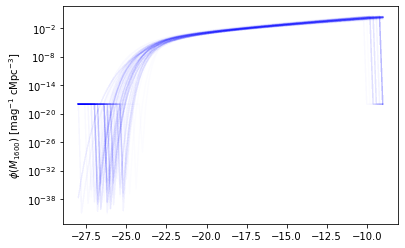

In [11]:
ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

ax.set_yscale('log')